## Define dataset and hyperparameters

In [1]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
train_data = datasets.MNIST(root='.',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())

test_data = datasets.MNIST(root='.',
                           train=False,
                           download=True,
                           transform=transforms.ToTensor())
print(type(train_data), type(test_data))
train_data, test_data

<class 'torchvision.datasets.mnist.MNIST'> <class 'torchvision.datasets.mnist.MNIST'>


(Dataset MNIST
     Number of datapoints: 60000
     Root location: .
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset MNIST
     Number of datapoints: 10000
     Root location: .
     Split: Test
     StandardTransform
 Transform: ToTensor())

In [4]:
train_data[0][0].size()

torch.Size([1, 28, 28])

In [5]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [6]:
batch_size = 100
original_dim = 28*28
latent_dim = 2
intermediate_dim = 256
epochs = 10
epsilon_std = 1

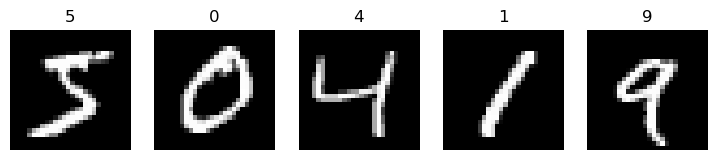

In [7]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 5, figsize=(9, 9))

for i in range(5):
  img = train_data[i][0]
  img_squeeze = img.squeeze()
  label = train_data[i][1]
  axs[i].imshow(img_squeeze, cmap="gray")
  axs[i].set_title(label)
  axs[i].axis('off');

## Define Encoder and Decoder

In [8]:
from torch import nn
from torch.nn import functional as F

class VAEEncoder(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAEEncoder, self).__init__()
        # fully connected layer
        self.fc1 = nn.Linear(original_dim, intermediate_dim)
        # mean layer
        self.fc_mean = nn.Linear(intermediate_dim, latent_dim)
        # log-variance layer
        self.fc_log_var = nn.Linear(intermediate_dim, latent_dim)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        # Get the mean of the latent space
        z_mean = self.fc_mean(h)
        # Get the log variance of the latent space
        z_log_var = self.fc_log_var(h)
        # Sample from the distribution having mean z_mean and log variance z_log_var
        z = self.reparameterize(z_mean, z_log_var)
        return z, z_mean, z_log_var
    
    def reparameterize(self, z_mean, z_log_var):
        # Standard deviation is calculated from log variance
        std = torch.exp(0.5 * z_log_var)
        # Random noise
        eps = torch.randn_like(std)
        # Sampling from the distribution
        return z_mean + eps * std

encoder = VAEEncoder(original_dim=784, intermediate_dim=512, latent_dim=2).to(device)
print(encoder)

VAEEncoder(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc_mean): Linear(in_features=512, out_features=2, bias=True)
  (fc_log_var): Linear(in_features=512, out_features=2, bias=True)
)


In [9]:
class VAEDecoder(nn.Module):
    def __init__(self, latent_dim, intermediate_dim, original_dim):
        super(VAEDecoder, self).__init__()
        # fully connected layer
        self.fc1 = nn.Linear(latent_dim, intermediate_dim)
        # output fully connected layer
        self.fc2 = nn.Linear(intermediate_dim, original_dim)

    def forward(self, z):
        h = F.relu(self.fc1(z))
        x_decoded = torch.sigmoid(self.fc2(h))
        return x_decoded

decoder = VAEDecoder(original_dim=784, intermediate_dim=512, latent_dim=2).to(device)

In [10]:
class VAE(nn.Module):
    def __init__(self, original_dim, intermediate_dim, latent_dim):
        super(VAE, self).__init__()
        self.encoder = VAEEncoder(original_dim, intermediate_dim, latent_dim)
        self.decoder = VAEDecoder(latent_dim, intermediate_dim, original_dim)

    def forward(self, x):
        z, z_mean, z_log_var = self.encoder(x)
        x_decoded = self.decoder(z)
        return x_decoded, z_mean, z_log_var

vae = VAE(original_dim=784, intermediate_dim=512, latent_dim=2).to(device)

In [11]:
def vae_loss_function(x, x_decoded, z_mean, z_log_var, original_dim):
    # Binary cross-entropy loss
    reconstruction_loss = F.binary_cross_entropy(x_decoded, x, reduction='sum')
    # KL divergence
    kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean.pow(2) - z_log_var.exp())
    return (reconstruction_loss + kl_loss) / original_dim

optimizer = torch.optim.Adam(vae.parameters(), lr=0.001)

In [12]:
def train_vae(model, data_loader, optimizer, num_epochs):
    model.train()
    for epoch in range(60):
        total_loss = 0
        for x, _ in data_loader:
            x = x.view(x.size(0), -1).to(device) 
            optimizer.zero_grad()
            x_decoded, z_mean, z_log_var = model(x)
            loss = vae_loss_function(x, x_decoded, z_mean, z_log_var, original_dim=784)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f'Epoch {epoch}, Loss: {total_loss / len(data_loader.dataset)}')

In [13]:
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [14]:
train_vae(vae, train_loader, optimizer, epochs)

Epoch 0, Loss: 0.238540815448761
Epoch 1, Loss: 0.21217334124247234
Epoch 2, Loss: 0.20787315537134807
Epoch 3, Loss: 0.20533857882817586
Epoch 4, Loss: 0.20338450498580932
Epoch 5, Loss: 0.20168538681666057
Epoch 6, Loss: 0.20027931362787882
Epoch 7, Loss: 0.19897739079793295
Epoch 8, Loss: 0.19791886103947956
Epoch 9, Loss: 0.1970305075963338
Epoch 10, Loss: 0.19632416127522787
Epoch 11, Loss: 0.19549109115600585
Epoch 12, Loss: 0.19488029985427857
Epoch 13, Loss: 0.1942699295361837
Epoch 14, Loss: 0.1937214383761088
Epoch 15, Loss: 0.19328516206741334
Epoch 16, Loss: 0.1927718729019165
Epoch 17, Loss: 0.19231986147562663
Epoch 18, Loss: 0.19190626328786214
Epoch 19, Loss: 0.1914825732866923
Epoch 20, Loss: 0.19115465571085613
Epoch 21, Loss: 0.19077969697316488
Epoch 22, Loss: 0.19042910375595093
Epoch 23, Loss: 0.19013484064737957
Epoch 24, Loss: 0.1898619085629781
Epoch 25, Loss: 0.1894803305308024
Epoch 26, Loss: 0.18919633363087973
Epoch 27, Loss: 0.18892618713378906
Epoch 28, L

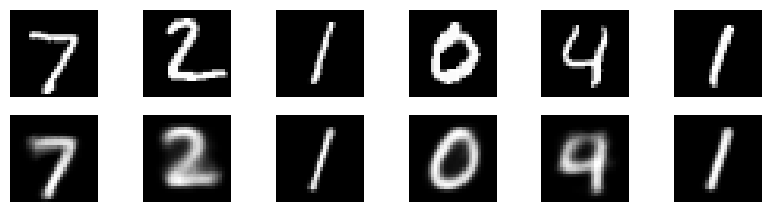

In [15]:
import matplotlib.pyplot as plt

def visualize_reconstructions(model, data_loader, device, n_images=6):
    model.eval()
    figure, ax = plt.subplots(2, n_images, figsize=(10, 2.5))
    with torch.inference_mode():
        for i, (x, _) in enumerate(data_loader):
            x = x.view(x.size(0), -1).to(device)
            x_decoded, _, _ = model(x)
            # Original images
            for j in range(n_images):
                ax[0, j].imshow(x[j].view(28, 28).cpu(), cmap='gray')
                ax[0, j].set_axis_off()
            # Reconstructed images
            for j in range(n_images):
                ax[1, j].imshow(x_decoded[j].view(28, 28).cpu(), cmap='gray')
                ax[1, j].set_axis_off()
            break 
    plt.show()

visualize_reconstructions(vae, test_loader, device, n_images=6)

In [16]:
def extract_latent_variables(model, data_loader, device):
    model.eval()
    z_points = []
    labels = []
    with torch.inference_mode():
        for x, y in data_loader:
            x = x.view(x.size(0), -1).to(device)
            _, z_mean, z_log_var = model.encoder(x)
            z = model.encoder.reparameterize(z_mean, z_log_var)
            z_points.append(z.cpu().numpy())
            labels.append(y.cpu().numpy())
    z_points = np.concatenate(z_points, axis=0)
    labels = np.concatenate(labels, axis=0)
    return z_points, labels

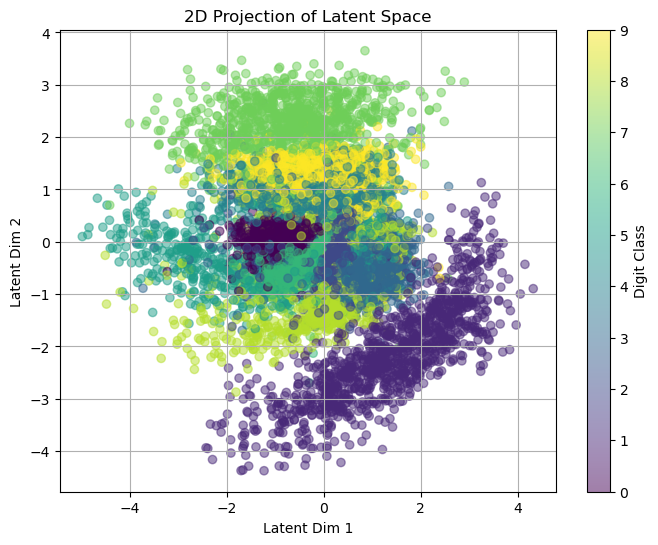

In [17]:
import numpy as np
import matplotlib.pyplot as plt

def plot_latent_space(z_points, labels):
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(z_points[:, 0], z_points[:, 1], c=labels, cmap='viridis', alpha=0.5)
    plt.colorbar(scatter, label='Digit Class')
    plt.xlabel('Latent Dim 1')
    plt.ylabel('Latent Dim 2')
    plt.title('2D Projection of Latent Space')
    plt.grid(True)
    plt.show()

z_points, labels = extract_latent_variables(vae, test_loader, device)
plot_latent_space(z_points, labels)

In [19]:
def decode_latent_points(decoder, latent_points):
    decoder.eval()
    with torch.no_grad():
        images = decoder(latent_points).cpu().numpy()
    return images.reshape(grid_size, grid_size, 28, 28)

In [20]:
import matplotlib.pyplot as plt

def plot_images(grid):
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10),
                            subplot_kw={'xticks': [], 'yticks': [], 'frame_on': False})
    plt.subplots_adjust(wspace=0, hspace=0)

    for i in range(grid_size**2):
        axs[i // grid_size, i % grid_size].imshow(grid[i // grid_size, i % grid_size], cmap='gray')
        axs[i // grid_size, i % grid_size].set_xticklabels([])
        axs[i // grid_size, i % grid_size].set_yticklabels([])
        axs[i // grid_size, i % grid_size].axis('off')

    plt.show()

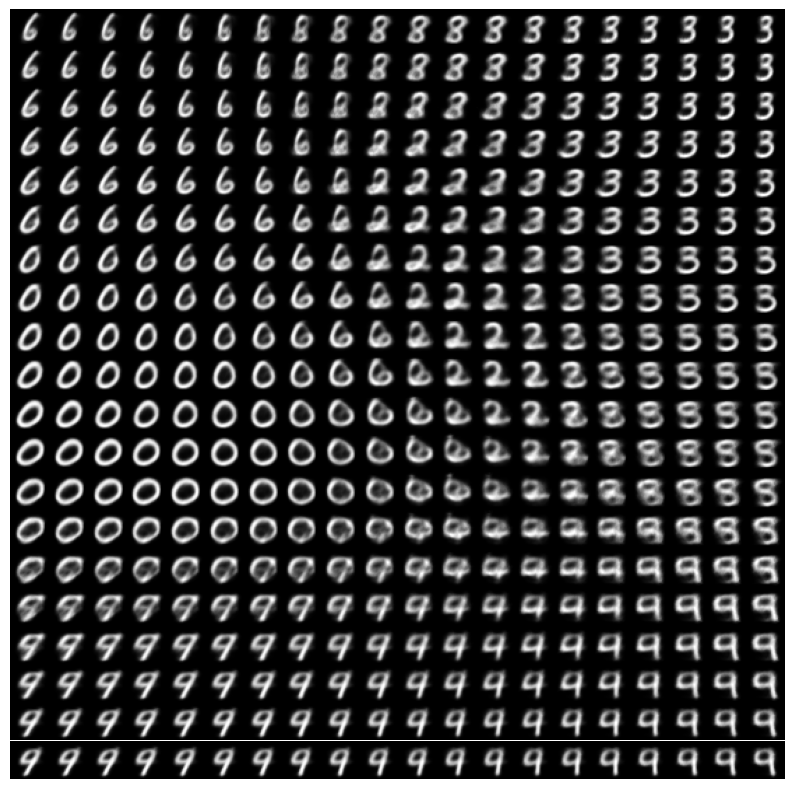

In [23]:
# Step 1: Generate latent points
grid_x = np.linspace(-1, 1, grid_size)
grid_y = np.linspace(-1, 1, grid_size)
mesh_x, mesh_y = np.meshgrid(grid_x, grid_y)
latent_points = np.empty((grid_size*grid_size, latent_dim))
latent_points[:, 0] = mesh_x.flatten()
latent_points[:, 1] = mesh_y.flatten()
latent_points = torch.from_numpy(latent_points).float().to(device)

# Step 2: Decode latent points
images = decode_latent_points(vae.decoder, latent_points)

# Step 3: Reshape and plot images
images = images.reshape(grid_size, grid_size, 28, 28)
plot_images(images)